### Titanic using XGBoost

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

### Step 1 : Data Ingestion

In [2]:
import pandas as pd
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

### Step 2 : Basic Date quality checks

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

### Step 3 : Saperate X and Y(Survived)

In [8]:
X = df.drop(columns=["PassengerId","Survived", "Name"])
Y = df[["Survived"]]

In [9]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Step 4 : Perform Preprocessing on X

In [11]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [12]:
cat = list(X.columns[X.dtypes == "object"])
con = list(X.columns[X.dtypes != "object"])

In [13]:
cat

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [14]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [20]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
)

In [21]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat)
    ]
).set_output(transform="pandas")

In [22]:
X_pre = pre.fit_transform(X)
X_pre

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_male,cat__Ticket_110413,cat__Ticket_110465,cat__Ticket_110564,cat__Ticket_110813,...,cat__Cabin_F G63,cat__Cabin_F G73,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F38,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_T,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.181487,-0.474545,-0.473674,-0.386671,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,-1.566107,-0.796286,-0.474545,-0.473674,-0.044381,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,0.827377,-0.104637,0.432793,2.008933,-0.176263,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,-1.566107,-0.258337,-0.474545,-0.473674,-0.044381,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 5 : train_test_split

In [112]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, random_state=21, test_size=0.3)

In [113]:
xtrain.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_male,cat__Ticket_110413,cat__Ticket_110465,cat__Ticket_110564,cat__Ticket_110813,...,cat__Cabin_F G63,cat__Cabin_F G73,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F38,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_T,cat__Embarked_Q,cat__Embarked_S
241,0.827377,-0.104637,0.432793,-0.473674,-0.336334,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
734,-0.369365,-0.488887,-0.474545,-0.473674,-0.386671,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
581,-1.566107,0.740711,0.432793,0.767630,1.584179,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,-1.566107,2.738807,-0.474545,-0.473674,-0.113846,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118,-1.566107,-0.412037,-0.474545,0.767630,4.335332,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
ytrain.head()

,Survived
241,1
734,0
581,1
456,0
118,0


In [115]:
xtest.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_male,cat__Ticket_110413,cat__Ticket_110465,cat__Ticket_110564,cat__Ticket_110813,...,cat__Cabin_F G63,cat__Cabin_F G73,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F38,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_T,cat__Embarked_Q,cat__Embarked_S
617,0.827377,-0.258337,0.432793,-0.473674,-0.324253,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
379,0.827377,-0.796286,-0.474545,-0.473674,-0.491874,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
725,0.827377,-0.719436,-0.474545,-0.473674,-0.474005,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
826,0.827377,-0.104637,-0.474545,-0.473674,0.489104,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
450,-0.369365,0.510161,0.432793,2.008933,-0.089684,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [116]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [117]:
xtrain.shape

(623, 834)

In [118]:
xtest.shape

(268, 834)

In [119]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [120]:
from xgboost import XGBClassifier

In [121]:
model = XGBClassifier(max_depth=3, learning_rate = 0.08, n_estimators = 300)
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [122]:
model.score(xtrain, ytrain)

0.9069020866773676

In [123]:
model.score(xtest, ytest)

0.8582089552238806

In [124]:
ypred_test = model.predict(xtest)
ypred_test[0:5]

array([0, 0, 0, 1, 0])

In [125]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [127]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="f1_macro")

scores

array([0.76674269, 0.83252239, 0.79258351, 0.79638752, 0.76340895])

In [128]:
scores.mean()

np.float64(0.7903290109912561)

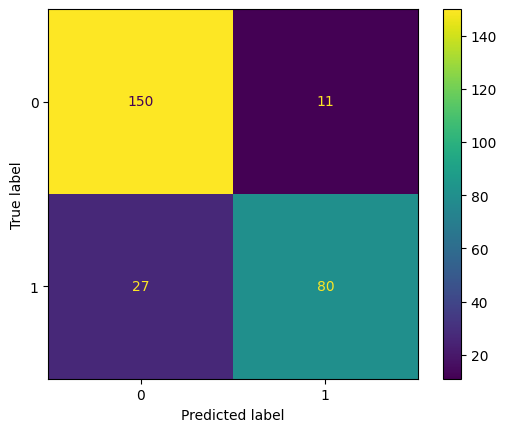

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [130]:
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       161
           1       0.88      0.75      0.81       107

    accuracy                           0.86       268
   macro avg       0.86      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268



### Feature Importances

In [131]:
model.feature_importances_

array([0.26949963, 0.03615887, 0.06515668, 0.03284268, 0.03482941,
       0.42781392, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [132]:
imp = pd.Series(model.feature_importances_, index=xtrain.columns)

In [133]:
imp

num__Pclass        0.269500
num__Age           0.036159
num__SibSp         0.065157
num__Parch         0.032843
num__Fare          0.034829
                     ...   
cat__Cabin_F4      0.000000
cat__Cabin_G6      0.000000
cat__Cabin_T       0.000000
cat__Embarked_Q    0.016644
cat__Embarked_S    0.072897
Length: 834, dtype: float32

In [137]:
imp.sort_values(ascending=False)

cat__Sex_male         0.427814
num__Pclass           0.269500
cat__Embarked_S       0.072897
num__SibSp            0.065157
cat__Cabin_B96 B98    0.044159
                        ...   
cat__Cabin_F4         0.000000
cat__Cabin_G6         0.000000
cat__Cabin_T          0.000000
cat__Ticket_110465    0.000000
cat__Cabin_E58        0.000000
Length: 834, dtype: float32

### Step 8 : Out of sample predictions

In [138]:
xnew = pd.read_csv("test.csv")
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [139]:
xnew.shape

(418, 11)

In [140]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [141]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Ticket', 'Cabin', 'Embarked'])])

In [142]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_male,cat__Ticket_110413,cat__Ticket_110465,cat__Ticket_110564,cat__Ticket_110813,...,cat__Cabin_F G63,cat__Cabin_F G73,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F38,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_T,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.394887,-0.474545,-0.473674,-0.490783,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.827377,1.355510,0.432793,-0.473674,-0.507479,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.369365,2.508257,-0.474545,-0.473674,-0.453367,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.827377,-0.181487,-0.474545,-0.473674,-0.474005,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.827377,-0.565736,0.432793,0.767630,-0.401017,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [143]:
preds = model.predict(xnew_pre)
preds[0:5]

array([0, 0, 0, 0, 0])

In [144]:
probs = model.predict_proba(xnew_pre)
probs[0:5]

array([[0.94794524, 0.05205474],
       [0.9492141 , 0.05078592],
       [0.9071461 , 0.09285389],
       [0.8860163 , 0.11398371],
       [0.76611745, 0.23388256]], dtype=float32)

In [145]:
probs_1 = probs[:, 1]
probs_1

array([0.05205474, 0.05078592, 0.09285389, 0.11398371, 0.23388256,
       0.09981716, 0.5523484 , 0.05913318, 0.90513116, 0.03010275,
       0.05854908, 0.10391632, 0.91307193, 0.1696126 , 0.9852024 ,
       0.89407057, 0.10920459, 0.45327783, 0.39874426, 0.36819535,
       0.5241625 , 0.856177  , 0.9755937 , 0.30441138, 0.96858215,
       0.01839656, 0.9810775 , 0.45327783, 0.40600723, 0.09284919,
       0.04819342, 0.12209371, 0.5286963 , 0.12843676, 0.76156527,
       0.3671815 , 0.29907313, 0.26004696, 0.09644278, 0.6296794 ,
       0.13623275, 0.40374708, 0.06912722, 0.9389564 , 0.98371315,
       0.14431837, 0.34387445, 0.06969504, 0.97514504, 0.70593375,
       0.52366495, 0.1383684 , 0.79353   , 0.74205536, 0.262194  ,
       0.00790217, 0.11344166, 0.20026067, 0.10865489, 0.9622647 ,
       0.07106902, 0.2794393 , 0.13458154, 0.59251505, 0.17373554,
       0.86513877, 0.6877808 , 0.07106545, 0.27002996, 0.87932974,
       0.7072617 , 0.04908962, 0.5918791 , 0.23626266, 0.96213

In [146]:
res = xnew[["PassengerId"]]
res

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [148]:
res["Survived"] = preds
res

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [149]:
res.to_csv("Titanic_Survived.csv", index=False)